<a href="https://colab.research.google.com/github/XaverB97/InfoRet/blob/main/Information_Retrieval_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [1]:
import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words("english"))
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Data Import [Emobank and Cornell]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

url = r'/content/drive/MyDrive/InfoRetr/emobank.csv'

dataset = pd.read_csv(url, index_col=0)

Mounted at /content/drive


In [3]:
movie_lines_features = ["LineID", "Character", "Movie", "Name", "Line"]
movie_lines = pd.read_csv("/content/drive/MyDrive/InfoRetr/cornell movie-dialogs corpus/movie_lines.txt", sep = "\+\+\+\$\+\+\+", engine = "python", index_col = False, names = movie_lines_features, encoding='unicode_escape')

# Strip the space from "LineID" for further usage and change the datatype of "Line"
movie_lines["LineID"] = movie_lines["LineID"].apply(str.strip)

movie_conversations_features = ["Character1", "Character2", "Movie", "Conversation"]
movie_conversations = pd.read_csv("/content/drive/MyDrive/InfoRetr/cornell movie-dialogs corpus/movie_conversations.txt", sep = "\+\+\+\$\+\+\+", engine = "python", index_col = False, names = movie_conversations_features,encoding='unicode_escape')

# Data Preprocessing


In [4]:
import string

def preprocess_dataframe(df):
    df['text'] = df['text'].astype(str)

    df['text'] = df['text'].str.lower().str.replace('<br /><br />', ' ')

    df['text'] = df['text'].str.replace('\s+', ' ', regex=True)

    df = df[~df['text'].str.isnumeric()].copy()

    df['word_counts'] = df['text'].apply(lambda x: len(x.split()))

    df['text'] = df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

    #df = df[df['text'].str.split().apply(len) >= 2].copy()

    return df

In [5]:
movie_lines['Movie'] = movie_lines['Movie'].str.replace(r'\D', '', regex=True)
movie_lines['LineID'] = movie_lines['LineID'].str.replace(r'\D', '', regex=True)
movie_lines['Character'] = movie_lines['Character'].str.replace(r'\D', '', regex=True)
movie_lines["Movie"]=movie_lines["Movie"].astype(int)
movie_lines["LineID"]=movie_lines["LineID"].astype(int)
movie_lines["Character"]=movie_lines["Character"].astype(int)
movie_lines = movie_lines.rename(columns={'Line': 'text'})


In [6]:
#Reading the dataset
df_emobank = pd.read_csv(url, index_col=0)

#Viewing the dataset
df_emobank.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10062 entries, 110CYL068_1036_1079 to wwf12_932_1053
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   split   10062 non-null  object 
 1   V       10062 non-null  float64
 2   A       10062 non-null  float64
 3   D       10062 non-null  float64
 4   text    10061 non-null  object 
dtypes: float64(3), object(2)
memory usage: 471.7+ KB


In [7]:
df = preprocess_dataframe(df_emobank)
df

,split,V,A,D,text,word_counts
id,,,,,,
110CYL068_1036_1079,train,3.00,3.00,3.20,remember said last letter,9
110CYL068_1079_1110,test,2.80,3.10,2.80,wasnt working,5
110CYL068_1127_1130,train,3.00,3.00,3.00,,1
110CYL068_1137_1188,train,3.44,3.00,3.22,goodwill helps people get public assistance,8
110CYL068_1189_1328,train,3.55,3.27,3.46,sherry learned future works class could rise m...,23
...,...,...,...,...,...,...
wwf12_4531_4624,train,3.00,3.50,3.00,please let constant reminder you’re preserve e...,16
wwf12_501_591,train,3.80,3.40,3.60,that’s want extend appreciation last membershi...,15
wwf12_592_691,train,3.00,3.00,3.10,i’m writing today ask renew support pivotal ye...,18


In [8]:
import scipy.stats as stats

df_norm = df
numerical_features = df.select_dtypes(include=np.number).columns

#Perform min-max scaling on numerical features
df_norm = (df[numerical_features] - df[numerical_features].min()) / (df[numerical_features].max() - df[numerical_features].min())

# Concatenate normalized features with original non-numerical features
df_norm = pd.concat([df_norm, df[['split', 'text']]], axis=1)

df_norm.head()

,V,A,D,word_counts,split,text
id,,,,,,
110CYL068_1036_1079,0.529412,0.461538,0.586777,0.069565,train,remember said last letter
110CYL068_1079_1110,0.470588,0.500000,0.421488,0.034783,test,wasnt working
110CYL068_1127_1130,0.529412,0.461538,0.504132,0.000000,train,
110CYL068_1137_1188,0.658824,0.461538,0.595041,0.060870,train,goodwill helps people get public assistance
110CYL068_1189_1328,0.691176,0.565385,0.694215,0.191304,train,sherry learned future works class could rise m...


In [9]:
df_norm.describe()

,V,A,D,word_counts
count,10062.000000,10062.000000,10062.000000,10062.000000
mean,0.522556,0.477610,0.530067,0.122024
std,0.102563,0.099824,0.086643,0.099101
min,0.000000,0.000000,0.000000,0.000000
25%,0.470588,0.419231,0.504132,0.043478
50%,0.529412,0.461538,0.541322,0.095652
75%,0.564706,0.538462,0.586777,0.173913
max,1.000000,1.000000,1.000000,1.000000


In [10]:
df_train = df_norm.loc[df_norm['split'] == 'train']
df_test = df_norm.loc[df_norm['split'] == 'test']

In [11]:
y_train_valence = df_train["V"].values
y_test_valence = df_test["V"].values

y_train_arousal = df_train["A"].values
y_test_arousal = df_test["A"].values

y_train_dominance = df_train["D"].values
y_test_dominance = df_test["D"].values

In [12]:
Y_train = pd.DataFrame({
    'Valence': y_train_valence,
    'Dominance': y_train_arousal,
    'Arousal': y_train_dominance
})

In [13]:
Y_test = pd.DataFrame({
    'Valence': y_test_valence,
    'Dominance': y_test_arousal,
    'Arousal': y_test_dominance
})

# **Model training**

In [14]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-11-21 09:43:42--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-21 09:43:42--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-21 09:43:42--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [15]:
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers


# Load GloVe embeddings from the downloaded file
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Tokenize text data
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df_norm["text"])
sequences_Emobank_train = tokenizer.texts_to_sequences(df_train["text"])
sequences_Emobank_test = tokenizer.texts_to_sequences(df_test["text"])

# Pad sequences to a fixed length
max_seq_length = 20
X_train = pad_sequences(sequences_Emobank_train, maxlen=max_seq_length)
X_test = pad_sequences(sequences_Emobank_test, maxlen=max_seq_length)

# Create embedding matrix
embedding_matrix = np.zeros((10000, 100))
for word, index in tokenizer.word_index.items():
    if index < 10000:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector


input_layer = Input(shape=(max_seq_length,))

lstm_layer = Embedding(10000, 100, weights=[embedding_matrix], trainable=False)(input_layer)

lstm_layer = Bidirectional(LSTM(64, dropout=0.25, return_sequences=True))(lstm_layer)
lstm_layer = Bidirectional(LSTM(32, dropout=0.25))(lstm_layer)  # No return_sequences for the last LSTM

# Separate output layers
valence_output = Dense(1, activation='sigmoid', name='valence', kernel_regularizer=regularizers.l2(0.01))(lstm_layer)
arousal_output = Dense(1, activation='sigmoid', name='arousal',kernel_regularizer=regularizers.l2(0.01))(lstm_layer)
dominance_output = Dense(1, activation='sigmoid', name='dominance',kernel_regularizer=regularizers.l2(0.01))(lstm_layer)


model = Model(inputs=input_layer, outputs=[valence_output, arousal_output, dominance_output])

optimizer = Adam(learning_rate=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer=optimizer,
              loss={'valence': Huber(), 'arousal': Huber(), 'dominance': Huber()},
              loss_weights={'valence': 1, 'arousal': 1, 'dominance': 1},
              metrics=['mae','mae','mae'])

# Fit the model
model.fit(X_train, {'valence': Y_train['Valence'], 'arousal': Y_train['Arousal'], 'dominance': Y_train['Dominance']},
          epochs=5, batch_size=16, validation_split=0.20, callbacks=[early_stopping])


Epoch 1/5
404/404 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - arousal_loss: 0.0049 - arousal_mae: 0.0799 - dominance_loss: 0.0045 - dominance_mae: 0.0938 - loss: 0.0413 - valence_loss: 0.0037 - valence_mae: 0.0702 - val_arousal_loss: 0.0051 - val_arousal_mae: 0.0793 - val_dominance_loss: 0.0046 - val_dominance_mae: 0.0963 - val_loss: 0.0146 - val_valence_loss: 0.0044 - val_valence_mae: 0.0715
Epoch 2/5
404/404 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - arousal_loss: 0.0047 - arousal_mae: 0.0796 - dominance_loss: 0.0040 - dominance_mae: 0.0964 - loss: 0.0125 - valence_loss: 0.0034 - valence_mae: 0.0669 - val_arousal_loss: 0.0050 - val_arousal_mae: 0.0931 - val_dominance_loss: 0.0045 - val_dominance_mae: 0.1016 - val_loss: 0.0141 - val_valence_loss: 0.0044 - val_valence_mae: 0.0711
Epoch 3/5
404/404 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - arousal_loss: 0.0046 - arousal_mae: 0.0834 - dominance_loss: 0.0038 - dominance_mae: 0.0997 - loss: 0.0121 - valence_loss: 0.0034 - valence_mae: 0.0667 - val_arousal_l

In [18]:
loss, valence_loss, arousal_loss, dominance_loss, valence_mae, arousal_mae, dominance_mae = model.evaluate(X_test, {'valence': Y_test['Valence'], 'arousal': Y_test['Arousal'], 'dominance': Y_test['Dominance']})

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - arousal_loss: 0.0039 - arousal_mae: 0.0850 - dominance_loss: 0.0034 - dominance_mae: 0.0977 - loss: 0.0108 - valence_loss: 0.0033 - valence_mae: 0.0634


# Getting Averages for all movies

In [19]:
from scipy.signal import savgol_filter
import plotly.express as px


vad_averages = pd.DataFrame(columns=["V", "A", "D", "Movie"])
# Iterate through unique movies
for movie_id in movie_lines['Movie'].unique():
    movie_lines_current = movie_lines.loc[movie_lines['Movie'] == movie_id]
    movie_lines_current = movie_lines_current.sort_values(by="LineID", ascending=True)
    movie_lines_current = preprocess_dataframe(movie_lines_current)
    movie_lines_current = movie_lines_current[movie_lines_current['text'].str.split().apply(len) >= 0].copy()

    # Tokenize
    sequences_current = tokenizer.texts_to_sequences(movie_lines_current["text"])
    x_array_current = pad_sequences(sequences_current, maxlen=max_seq_length)

    # Predict
    predictions_current = model.predict(x_array_current)
    predictions_2d_current = np.hstack([predictions_current[0], predictions_current[1], predictions_current[2]])
    df_describe_current = pd.DataFrame(predictions_2d_current, columns=['valence', 'arousal', 'dominance'])

    # Combine
    df_describe_with_movie_current = pd.concat([df_describe_current.reset_index(drop=True),movie_lines_current.reset_index(drop=True)], axis=1)
    df_describe_with_movie_current.columns=["V","A","D","LineID","character",	"Movie",	"Name",	"text","sequence length"]

    average_vad = df_describe_with_movie_current[["V", "A", "D"]].mean()

    # Create a new DataFrame
    new_row = pd.DataFrame({
        "V": [average_vad["V"]],
        "A": [average_vad["A"]],
        "D": [average_vad["D"]],
        "Movie": [df_describe_with_movie_current['Movie'].iloc[0]]
    })

    # Append the new row to vad_averages
    vad_averages = pd.concat([vad_averages, new_row], ignore_index=True)


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
18/18 ━━━━━━

In [20]:
vad_averages

,V,A,D,Movie
0,0.529502,0.495995,0.509525,0
1,0.529058,0.488326,0.508180,1
2,0.526102,0.499316,0.501840,2
3,0.531685,0.490250,0.515548,3
4,0.529723,0.500439,0.506983,4
...,...,...,...,...
612,0.527266,0.495688,0.502472,612
613,0.528330,0.499571,0.501626,613
614,0.527629,0.490857,0.503281,614
615,0.531397,0.492439,0.518035,615


In [21]:
movie_genres_features = ["Movie", "Name", "Year", "Rating", "Number","Genre"]
movie_genres = pd.read_csv("/content/drive/MyDrive/InfoRetr/cornell movie-dialogs corpus/movie_titles_metadata.txt", sep = "\+\+\+\$\+\+\+", engine = "python", index_col = False, names = movie_genres_features, encoding='unicode_escape')

In [22]:

movie_genres['Movie'] = movie_genres['Movie'].astype(str).str.replace('m', '', regex=False)

#  to numeric
movie_genres['Movie'] = pd.to_numeric(movie_genres['Movie'], errors='coerce')
vad_averages['Movie'] = pd.to_numeric(vad_averages['Movie'], errors='coerce')

# join
merged_df = pd.merge(movie_genres, vad_averages, on="Movie", how="inner")

merged_df

,Movie,Name,Year,Rating,Number,Genre,V,A,D
0,0,10 things i hate about you,1999,6.9,62847,"['comedy', 'romance']",0.529502,0.495995,0.509525
1,1,1492: conquest of paradise,1992,6.2,10421,"['adventure', 'biography', 'drama', 'history']",0.529058,0.488326,0.508180
2,2,15 minutes,2001,6.1,25854,"['action', 'crime', 'drama', 'thriller']",0.526102,0.499316,0.501840
3,3,2001: a space odyssey,1968,8.4,163227,"['adventure', 'mystery', 'sci-fi']",0.531685,0.490250,0.515548
4,4,48 hrs.,1982,6.9,22289,"['action', 'comedy', 'crime', 'drama', 'thril...",0.529723,0.500439,0.506983
...,...,...,...,...,...,...,...,...,...
612,612,watchmen,2009,7.8,135229,"['action', 'crime', 'fantasy', 'mystery', 'sc...",0.527266,0.495688,0.502472
613,613,xxx,2002,5.6,53505,"['action', 'adventure', 'crime']",0.528330,0.499571,0.501626
614,614,x-men,2000,7.4,122149,"['action', 'sci-fi']",0.527629,0.490857,0.503281
615,615,young frankenstein,1974,8.0,57618,"['comedy', 'sci-fi']",0.531397,0.492439,0.518035


# Getting averages for all Genres

In [23]:
def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', str(text))

In [24]:

import pandas as pd

# dictionary for genre
genre_vad_averages = {}

# Iterate over each row in the merged DataFrame

for index, row in merged_df.iterrows():
    movie_genres = row['Genre'].split(',')  # Split the genres string
    # Iterate through each genre in the list and apply the function
    cleaned_genres = [remove_special_characters(genre) for genre in movie_genres]
    for genre in cleaned_genres: #Iterating through each genre in the cleaned genres list
        if genre not in genre_vad_averages:
            genre_vad_averages[genre] = {'V': [], 'A': [], 'D': []}
        genre_vad_averages[genre]['V'].append(row['V'])
        genre_vad_averages[genre]['A'].append(row['A'])
        genre_vad_averages[genre]['D'].append(row['D'])


In [25]:

# Calculate the average VAD values for each genre
results = {}
for genre, vad_values in genre_vad_averages.items():
  results[genre] = {
      'V_avg': sum(vad_values['V']) / len(vad_values['V']),
      'A_avg': sum(vad_values['A']) / len(vad_values['A']),
      'D_avg': sum(vad_values['D']) / len(vad_values['D'])
  }

# Convert the results to dataframe
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.reset_index()
results_df = results_df.rename(columns={'index': 'genre'})

results_df

,genre,V_avg,A_avg,D_avg
0,comedy,0.530248,0.496905,0.512210
1,romance,0.530254,0.496596,0.512627
2,adventure,0.529232,0.493728,0.509861
3,biography,0.529710,0.495436,0.510377
4,drama,0.529401,0.496167,0.509938
5,history,0.529644,0.492453,0.510764
6,action,0.528637,0.494713,0.507943
7,crime,0.528325,0.496453,0.507100
8,thriller,0.528120,0.495489,0.506825
9,mystery,0.527596,0.495372,0.505647


In [26]:
#drop the one empty one
results_df = results_df[results_df['genre'] != ' ']

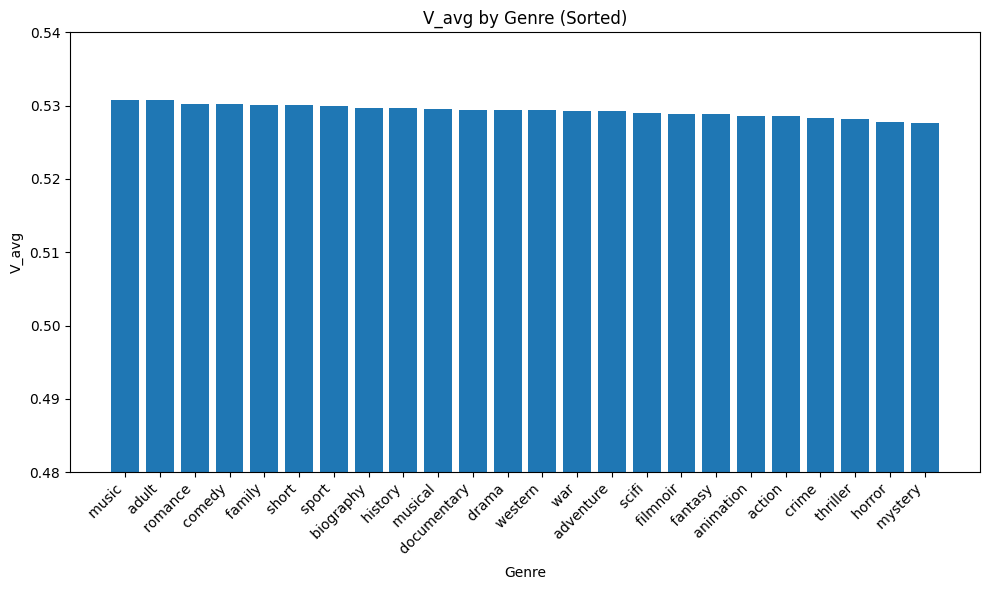

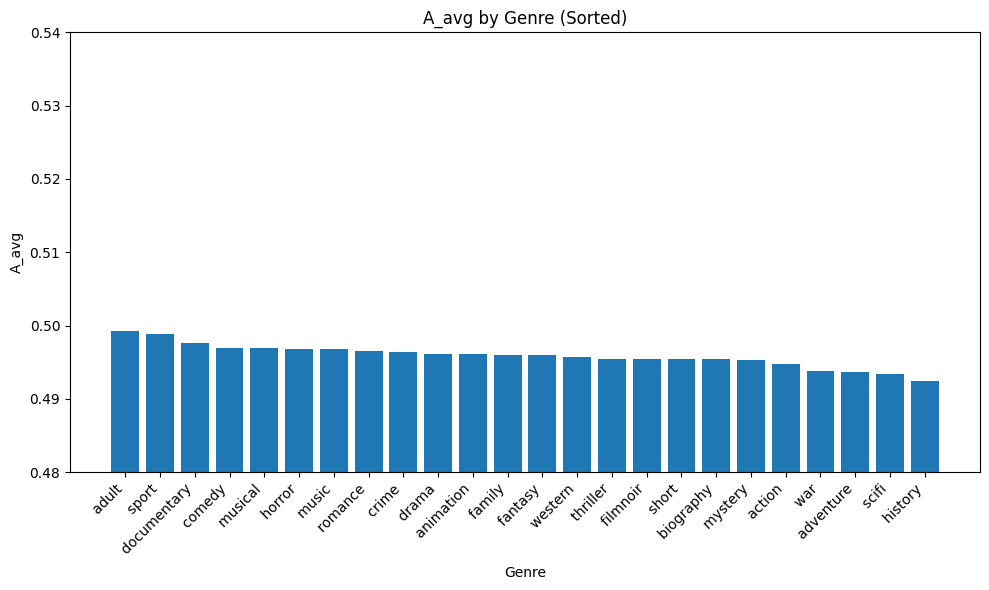

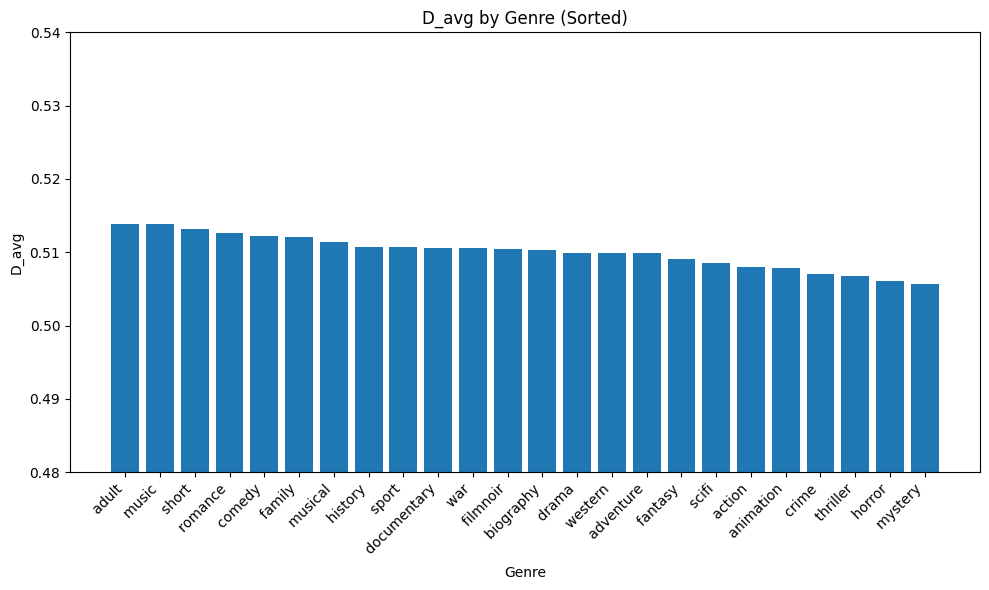

In [27]:
import matplotlib.pyplot as plt

def create_digrams(df, metric):
    df_sorted = df.sort_values(by=metric, ascending=False)
    plt.figure(figsize=(10, 6))
    plt.bar(df_sorted['genre'], df_sorted[metric])
    plt.xlabel("Genre")
    plt.ylabel(metric)
    plt.title(f"{metric} by Genre (Sorted)")
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0.48, 0.54)
    plt.tight_layout()
    plt.show()


# Create digrams
create_digrams(results_df, 'V_avg')
create_digrams(results_df, 'A_avg')
create_digrams(results_df, 'D_avg')

In [28]:
movie_lines

,LineID,Character,Movie,Name,text
0,1045,0,0,BIANCA,They do not!
1,1044,2,0,CAMERON,They do to!
2,985,0,0,BIANCA,I hope so.
3,984,2,0,CAMERON,She okay?
4,925,0,0,BIANCA,Let's go.
...,...,...,...,...,...
304708,666371,9030,616,DURNFORD,Lord Chelmsford seems to want me to stay back...
304709,666370,9034,616,VEREKER,I'm to take the Sikali with the main column t...
304710,666369,9030,616,DURNFORD,"Your orders, Mr Vereker?"
304711,666257,9030,616,DURNFORD,"Good ones, yes, Mr Vereker. Gentlemen who can..."


# Getting averages for all main characters

In [29]:
vad_averages_main_character = pd.DataFrame(columns=["V", "A", "D", "Movie", "Character"])

for movie_id in movie_lines['Movie'].unique():
    movie_lines_current = movie_lines[movie_lines['Movie'] == movie_id]
    movie_lines_current = movie_lines_current.sort_values(by="LineID", ascending=True)
    movie_lines_current = preprocess_dataframe(movie_lines_current)
    movie_lines_current = movie_lines_current[movie_lines_current['text'].str.split().apply(len) >= 0]

    # Find the main character
    character_counts = movie_lines_current['Name'].value_counts()
    main_character = character_counts.index[0]

    if main_character is not None:
      movie_lines_main_char = movie_lines_current[movie_lines_current["Name"] == main_character]

      sequences_current = tokenizer.texts_to_sequences(movie_lines_main_char["text"])
      x_array_current = pad_sequences(sequences_current, maxlen=max_seq_length)

      predictions_current = model.predict(x_array_current)
      predictions_2d_current = np.hstack([predictions_current[0], predictions_current[1], predictions_current[2]])
      df_describe_current = pd.DataFrame(predictions_2d_current, columns=['valence', 'arousal', 'dominance'])


      average_vad = df_describe_current[["valence", "arousal", "dominance"]].mean()
      std_vad = df_describe_current[["valence", "arousal", "dominance"]].std()

      new_row = pd.DataFrame({
          "V": [average_vad["valence"]],
          "A": [average_vad["arousal"]],
          "D": [average_vad["dominance"]],
          "V_std": [std_vad["valence"]],
          "A_std": [std_vad["arousal"]],
          "D_std": [std_vad["dominance"]],
          "Movie": [movie_id],
          "Character": [main_character],
      })
      vad_averages_main_character = pd.concat([vad_averages_main_character, new_row], ignore_index=True)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━

# Using main character avg and std to decide which movie to analyze

In [30]:
vad_averages_main_character = pd.merge(vad_averages_main_character, merged_df[['Movie', 'Genre']], on='Movie', how='left')


In [31]:
vad_averages_main_character

,V,A,D,Movie,Character,V_std,A_std,D_std,Genre
0,0.528671,0.494200,0.505736,0,KAT,0.013493,0.014036,0.031788,"['comedy', 'romance']"
1,0.531872,0.488333,0.514034,1,COLUMBUS,0.012771,0.016496,0.030910,"['adventure', 'biography', 'drama', 'history']"
2,0.523604,0.500535,0.495805,2,JORDY,0.017339,0.015040,0.042784,"['action', 'crime', 'drama', 'thriller']"
3,0.530189,0.492096,0.507954,3,BOWMAN,0.014733,0.018100,0.035522,"['adventure', 'mystery', 'sci-fi']"
4,0.529684,0.501437,0.506658,4,CATES,0.016608,0.014070,0.040456,"['action', 'comedy', 'crime', 'drama', 'thril..."
...,...,...,...,...,...,...,...,...,...
612,0.529463,0.495708,0.507848,612,LAURIE,0.014431,0.015307,0.037239,"['action', 'crime', 'fantasy', 'mystery', 'sc..."
613,0.527736,0.501503,0.500194,613,XANDER,0.017440,0.014583,0.042518,"['action', 'adventure', 'crime']"
614,0.527938,0.498574,0.504519,614,LOGAN,0.015114,0.013093,0.036666,"['action', 'sci-fi']"
615,0.531442,0.493239,0.516213,615,FREDDY,0.014021,0.017383,0.035127,"['comedy', 'sci-fi']"


# Final destination 2 movie analysis

In [32]:
movie_lines_FD2 = movie_lines.loc[movie_lines['Movie'] == 349]
movie_lines_FD2 = movie_lines_FD2.sort_values(by="LineID", ascending=True)

movie_lines_FD2 = preprocess_dataframe(movie_lines_FD2)

movie_lines_FD2 = movie_lines_FD2[movie_lines_FD2['text'].str.split().apply(len) >= 1].copy()  # Drop rows with less than 1 words

movie_lines_FD2.describe()

sequences_FD2 = tokenizer.texts_to_sequences(movie_lines_FD2["text"])

# Pad sequences to a fixed length
x_array = pad_sequences(sequences_FD2, maxlen=max_seq_length)

print(x_array)

[[   0    0    0 ... 2818  650  139]
 [   0    0    0 ... 1100    1  351]
 [   0    0    0 ... 2818    1    1]
 ...
 [   0    0    0 ...    0   25  306]
 [   0    0    0 ...  296  532 2818]
 [   0    0    0 ...   17 6548    1]]


In [33]:
predictions = model.predict(x_array)

predictions_2d = np.hstack([predictions[0], predictions[1], predictions[2]])

df_describe = pd.DataFrame(predictions_2d, columns=['valence', 'arousal', 'dominance'])  # Assign column names
df_describe.describe()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


,valence,arousal,dominance
count,247.000000,247.000000,247.000000
mean,0.522446,0.498378,0.493200
std,0.018965,0.018275,0.044265
min,0.471306,0.439268,0.396485
25%,0.511183,0.487760,0.465943
50%,0.526527,0.502774,0.499062
75%,0.535502,0.512295,0.522908
max,0.564891,0.531513,0.611751


In [34]:
import pandas as pd
from scipy.signal import savgol_filter

window_length = 30
polyorder = 2

df_describe['valence_smooth'] = savgol_filter(df_describe['valence'], window_length, polyorder)
df_describe['arousal_smooth'] = savgol_filter(df_describe['arousal'], window_length, polyorder)
df_describe['dominance_smooth'] = savgol_filter(df_describe['dominance'], window_length, polyorder)

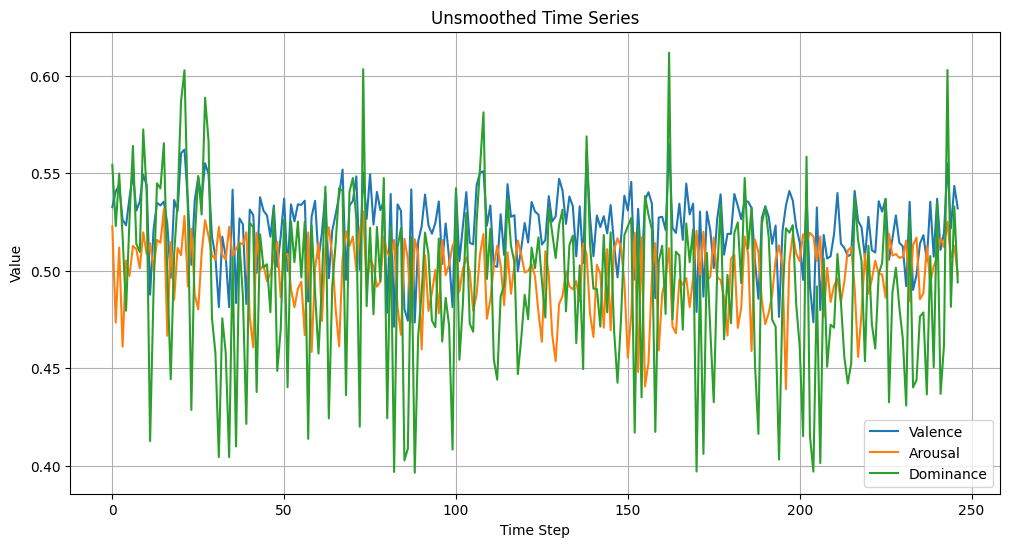

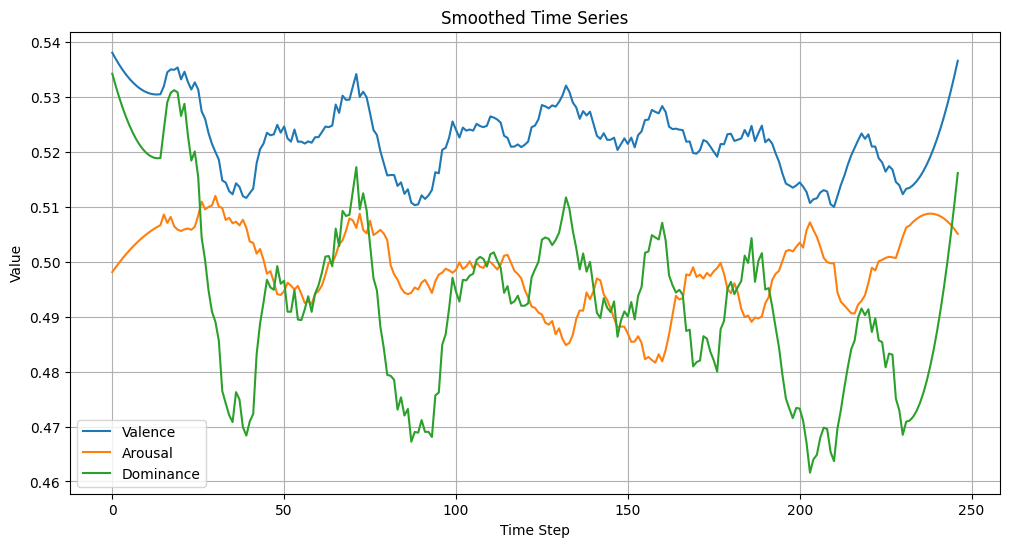

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(df_describe['valence'], label='Valence')
plt.plot(df_describe['arousal'], label='Arousal')
plt.plot(df_describe['dominance'], label='Dominance')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Unsmoothed Time Series')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df_describe['valence_smooth'], label='Valence')
plt.plot(df_describe['arousal_smooth'], label='Arousal')
plt.plot(df_describe['dominance_smooth'], label='Dominance')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Smoothed Time Series')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
df_describe_with_movie = pd.concat([df_describe.reset_index(drop=True),movie_lines_FD2.reset_index(drop=True)], axis=1)
df_describe_with_movie.columns=["V","A","D","Vsm","Asm","Dsm","LineID","character",	"Movie",	"Name",	"text","sequence length"]
df_describe_with_movie.head(800)

,V,A,D,Vsm,Asm,Dsm,LineID,character,Movie,Name,text,sequence length
0,0.532589,0.522780,0.554323,0.537985,0.498087,0.534168,214899,5281,349,KIMBERLY,thanks dad ill call,5
1,0.540755,0.473421,0.522905,0.536855,0.498961,0.531932,214900,5282,349,MR. BURROUGHS,everything kimberly credit card cell phone aaa...,10
2,0.543650,0.511913,0.549817,0.535816,0.499794,0.529870,214901,5281,349,KIMBERLY,relax dad daytona mongolia,6
3,0.526162,0.461066,0.517527,0.534868,0.500586,0.527984,214902,5282,349,MR. BURROUGHS,fixaflat road flares sunblock mace,5
4,0.523299,0.505260,0.479526,0.534011,0.501338,0.526274,214906,5281,349,KIMBERLY,know first time weve apart since everythings g...,16
...,...,...,...,...,...,...,...,...,...,...,...,...
242,0.519416,0.512152,0.461927,0.526370,0.507820,0.495416,215522,5287,349,THOMAS,thats crazy cant give still fight thing,13
243,0.555080,0.525234,0.602941,0.528643,0.507301,0.500003,215529,5281,349,KIMBERLY,welcome back real,7
244,0.521682,0.506340,0.481487,0.531092,0.506666,0.504980,215530,5287,349,THOMAS,know feel,7
245,0.543508,0.512764,0.532964,0.533720,0.505913,0.510349,215535,5281,349,KIMBERLY,gods sake leave alone dad,7


In [37]:
import plotly.express as px
import random

dfg = df_describe_with_movie.groupby(['Name']).size().to_frame().sort_values([0], ascending = False).head(20).reset_index()
dfg.columns = ['name', 'count']

# plotly
fig = px.histogram(dfg, x='name', y = 'count')
fig.layout.yaxis.title.text = 'count'
fig.show()

In [38]:
df_Kimberley = df_describe_with_movie.loc[(df_describe_with_movie['character'] == 5281 )]
df_Kimberley.columns=["V","A","D","Vsm","Asm","Dsm","LineIN","character",	"Movie",	"Name",	"text","sequence length"]
df_Kimberley.head()

,V,A,D,Vsm,Asm,Dsm,LineIN,character,Movie,Name,text,sequence length
0,0.532589,0.522780,0.554323,0.537985,0.498087,0.534168,214899,5281,349,KIMBERLY,thanks dad ill call,5
2,0.543650,0.511913,0.549817,0.535816,0.499794,0.529870,214901,5281,349,KIMBERLY,relax dad daytona mongolia,6
4,0.523299,0.505260,0.479526,0.534011,0.501338,0.526274,214906,5281,349,KIMBERLY,know first time weve apart since everythings g...,16
7,0.530800,0.510967,0.513722,0.531983,0.503349,0.522197,214909,5281,349,KIMBERLY,know dad,3
9,0.549212,0.519687,0.572423,0.531086,0.504486,0.520357,214915,5281,349,KIMBERLY,im good,3


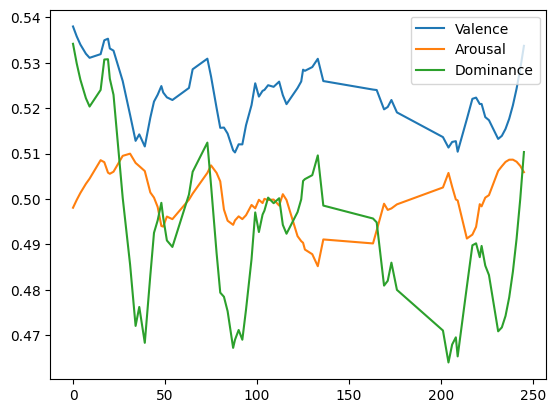

In [39]:
plt.plot(df_Kimberley["Vsm"],label='Valence')
plt.plot(df_Kimberley["Asm"],label='Arousal')
plt.plot(df_Kimberley["Dsm"],label='Dominance')
plt.legend()
plt.show()

In [40]:
df_Thomas = df_describe_with_movie.loc[(df_describe_with_movie['character'] == 5287 )]
df_Thomas.columns=["V","A","D","Vsm","Asm","Dsm","LineIN","character",	"Movie",	"Name",	"text","sequence length"]
df_Thomas.head()

,V,A,D,Vsm,Asm,Dsm,LineIN,character,Movie,Name,text,sequence length
38,0.523857,0.513344,0.487043,0.511893,0.507599,0.469892,214986,5287,349,THOMAS,whats going,4
43,0.537646,0.500418,0.518713,0.520428,0.502274,0.488752,214996,5287,349,THOMAS,alright miss calm need lane open need pull veh...,20
45,0.528362,0.494584,0.503338,0.523428,0.497791,0.496682,215009,5287,349,THOMAS,tell started,6
47,0.533442,0.506683,0.532009,0.523140,0.496285,0.494870,215011,5287,349,THOMAS,remember triggered,7
52,0.534061,0.490747,0.525196,0.521822,0.495630,0.490872,215017,5287,349,THOMAS,like,2


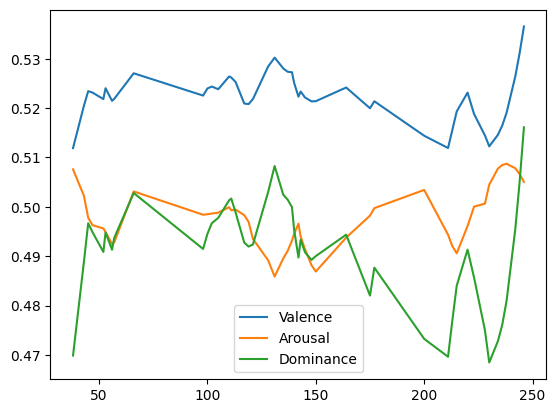

In [41]:
plt.plot(df_Thomas["Vsm"],label='Valence')
plt.plot(df_Thomas["Asm"],label='Arousal')
plt.plot(df_Thomas["Dsm"],label='Dominance')
plt.legend()
plt.show()

<Axes: xlabel='V', ylabel='Name'>

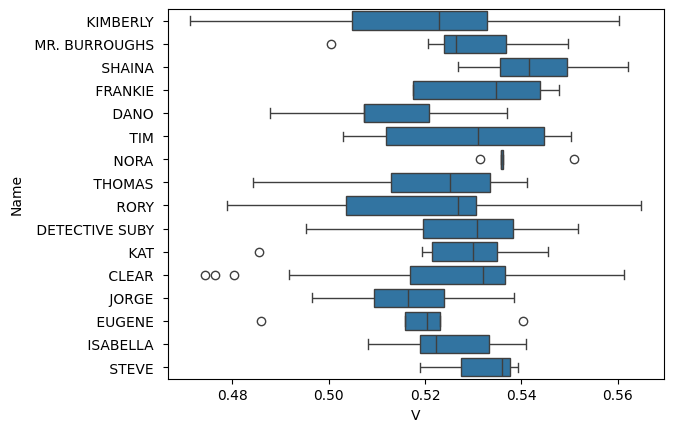

In [42]:
sns.boxplot(data=df_describe_with_movie, x="V", y="Name")

<Axes: xlabel='A', ylabel='Name'>

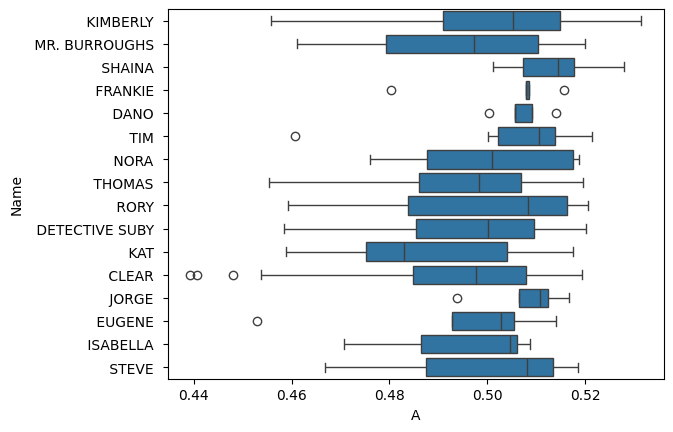

In [43]:
sns.boxplot(data=df_describe_with_movie, x="A", y="Name")

<Axes: xlabel='D', ylabel='Name'>

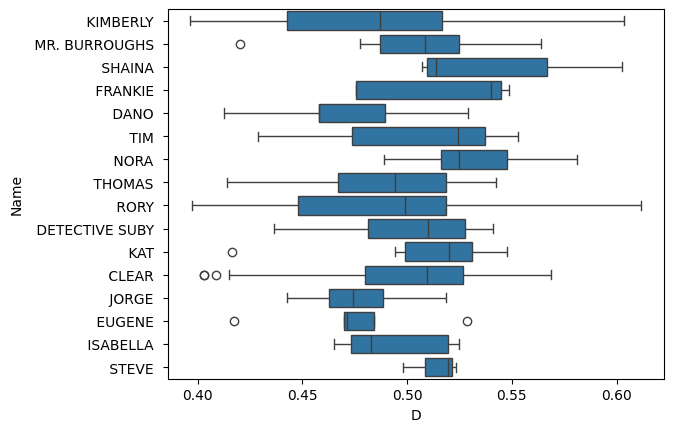

In [44]:
sns.boxplot(data=df_describe_with_movie, x="D", y="Name")